In [1]:
import pprint
import time
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from src.groupkfold import GroupKFoldWithSeed
from src.seed import seed_everything

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 20
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
cb:
  params:
    loss_function: Logloss
    eval_metric: Logloss
    learning_rate: 0.05
    depth: 5
    max_leaves: 31
    min_data_in_leaf: 20
    subsample: 0.8
    rsm: 0.8
    l2_leaf_reg: 1
    random_seed: 42
    allow_writing_files: false
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '001'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  cloth_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/00

### Import

In [2]:
train_df = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
cloth_df = pl.read_csv(cfg.data.cloth_path, try_parse_dates=True)
test_df = pl.read_csv(cfg.data.test_path, try_parse_dates=True)

train_df = train_df.join(cloth_df, on="Clothing ID", how="left")
test_df = test_df.join(cloth_df, on="Clothing ID", how="left")

skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)


In [3]:
# ラベルエンコーディング

le_division_name = LabelEncoder()
le_division_name.fit(cloth_df["Division Name"])
train_df = train_df.with_columns(
    pl.Series(le_division_name.transform(train_df["Division Name"])).alias("Division Name")
)
test_df = test_df.with_columns(pl.Series(le_division_name.transform(test_df["Division Name"])).alias("Division Name"))

le_department_name = LabelEncoder()
le_department_name.fit(cloth_df["Department Name"])
train_df = train_df.with_columns(
    pl.Series(le_department_name.transform(train_df["Department Name"])).alias("Department Name")
)
test_df = test_df.with_columns(
    pl.Series(le_department_name.transform(test_df["Department Name"])).alias("Department Name")
)

le_class_name = LabelEncoder()
le_class_name.fit(cloth_df["Class Name"])
train_df = train_df.with_columns(pl.Series(le_class_name.transform(train_df["Class Name"])).alias("Class Name"))
test_df = test_df.with_columns(pl.Series(le_class_name.transform(test_df["Class Name"])).alias("Class Name"))


In [4]:
display(train_df.head())
display(test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
i64,i64,str,str,i64,i64,i64,i64,i64,i64
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12
0,45,null,"""I was really pleased with this…",5,1,9,0,0,12
0,57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,0,0,12


Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
i64,i64,str,str,i64,i64,i64,i64
0,32,"""So happy i bought this skirt!""","""I love this skirt. it does run…",0,0,0,12
0,34,"""Runs small""","""Beautiful patterns and colors,…",0,0,0,12
0,37,"""Love the comfort of thi skirt""","""It is easily paired with a nic…",0,0,0,12
0,39,"""Way too small""","""This is a beautiful skirt, but…",10,0,0,12
0,39,null,"""I usually wear a size 8/10 and…",0,0,0,12


### 学習

In [5]:
x_train = train_df.drop([cfg.target, "Rating", "Title", "Review Text"]).to_pandas()
y_train = train_df[cfg.target].to_pandas()

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    # categorical_feature=x_train.select_dtypes(include=["category"]).columns.tolist(),
    free_raw_data=True,
)
callbacks = [
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation),
]

# 学習
cv_results = lgb.cv(
    dict(cfg.lgb.params),
    lgb_data,
    folds=skf.split(x_train, y_train),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    stratified=False,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster = cv_results["cvbooster"]
cvbooster.save_model(f"{cfg.data.results_dir}/model.pkl")


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid auc: 0.584908 + 0.0122912
[200]	cv_agg's valid auc: 0.587249 + 0.0124249
[300]	cv_agg's valid auc: 0.588479 + 0.0116917
[400]	cv_agg's valid auc: 0.588671 + 0.0118737
[500]	cv_agg's valid auc: 0.589718 + 0.0114833
Early stopping, best iteration is:
[482]	cv_agg's valid auc: 0.589966 + 0.0115969


### log

In [7]:
best_iteration = cvbooster.best_iteration
best_score = cv_results["valid auc-mean"][best_iteration - 1]
best_score_stdv = cv_results["valid auc-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score (auc): {best_score}\n")
    log_file.write(f"best_score_stdv (auc): {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


### Feature Importance

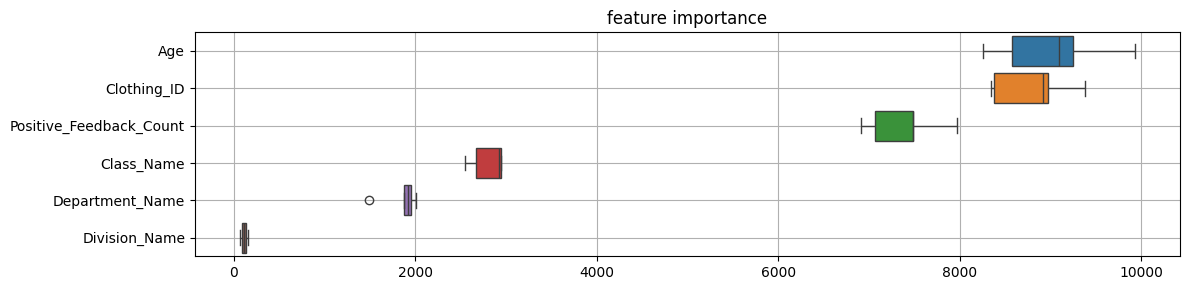

In [8]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance.png")


### oof

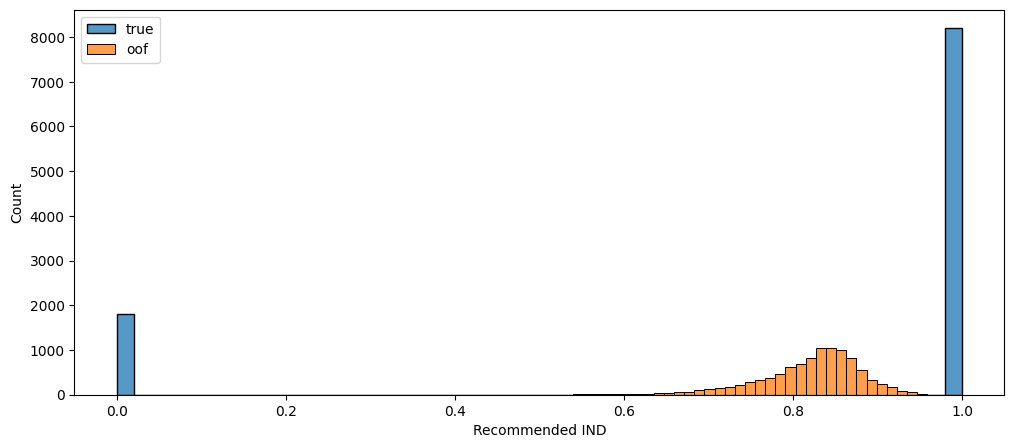

In [9]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(skf.split(x_train, y_train)):
    x_valid = x_train.iloc[valid_idx]
    model = cvbooster.boosters[i]
    y_pred = model.predict(x_valid, num_iteration=cvbooster.best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### Submission

In [10]:
# 推論
x_test = test_df.drop(["Title", "Review Text"]).to_pandas()
y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = y_pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


,target
0,0.873447
1,0.886798
2,0.891018
3,0.787781
4,0.897726
